In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
# import string
import math

# import scipy.stats as sts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
# import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
# from sklearn import discriminant_analysis as disan
# from sklearn import calibration as calib
# from sklearn import linear_model as lm
# from sklearn import svm
# from sklearn import gaussian_process as gaup
# from sklearn import mixture as mix
# from sklearn import tree
# from sklearn import ensemble as ens

import tensorflow as tf
from tensorflow import keras

# from keras import models as kermdls
# from keras import layers as kerlrs
# from keras import metrics as kmetrics

# from hyperas import optim
# from hyperas.distributions import choice, uniform
# from hyperopt import Trials, STATUS_OK, tpe

# import pickle

# import nilearn as nl
# from nilearn import plotting, image
# from nilearn import datasets
# import nibabel as nb
import h5py

import os

import time

In [2]:
TEST_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_test'))]
TRAIN_IDS = [map_id.split('.')[0] for map_id in sorted(os.listdir('00_Data/fMRI_train'))]

In [3]:
data = pd.read_csv('00_Data/train_scores_full.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10007,38.617381,49.197021,65.674285,40.151376,34.096421
4,10008,35.326582,15.769168,65.782269,44.643805,50.448485
...,...,...,...,...,...,...
5872,21654,53.103634,50.951656,62.168022,49.389400,53.020847
5873,21665,38.246437,48.018227,59.522285,45.697098,53.208160
5874,21674,69.414169,58.593918,60.298779,49.865669,47.863167
5875,21693,62.009209,54.272484,60.474388,52.325031,52.989803


In [4]:
data.isnull().sum()

Id              0
age             0
domain1_var1    0
domain1_var2    0
domain2_var1    0
domain2_var2    0
dtype: int64

In [5]:
print('Dataset length: ', len(data.index))

Dataset length:  5877


In [6]:
def get_inputs(idx, labels):
    # FNC inputs
    df_fnc = pd.read_csv('00_Data/fnc_csv/{0}.csv'.format(idx), index_col=0)
    X_fnc = np.array(df_fnc.values).reshape(-1)
    
    # Loading inputs
    df_loading = pd.read_csv('00_Data/loading_csv/{0}.csv'.format(idx), index_col=0)
    X_loading = np.array(df_loading.values).reshape(-1)
    
    #MRI inputs
    patient_SM = h5py.File('00_Data/fMRI_train/{0}.mat'.format(idx), mode='r')
    patient_SM = np.array(patient_SM.get('SM_feature'))
    
    k = 2
    ki_padding = 3
    
    arr_regions = []
    for i in range(patient_SM.shape[0]):
        sample_map = patient_SM[i,:,:,:]
        # padding MRI map
        map_shape = sample_map.shape
        shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                     (map_shape[1]//k + 1)*k - map_shape[1],
                     (map_shape[2]//k + 1)*k - map_shape[2])

        npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

        sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

        sx = sample_map_padded.shape[0] / k
        sy = sample_map_padded.shape[1] / k
        sz = sample_map_padded.shape[2] / k
        for kz in range(k):
            for ky in range(k):
                for kx in range(k):
                    ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                 int(ky*sy): int(ky*sy + sy - 1), 
                                                 int(kz*sz): int(kz*sz + sz - 1)]
                    # padding i-th region by 3 pixels
                    ki_region_padded = np.pad(ki_region, pad_width=ki_padding, mode='constant', constant_values=0)
                    arr_regions.append(ki_region_padded)
    X_mri = np.stack(arr_regions, axis=3)
    
    X = (X_mri, X_fnc, X_loading)
    return X, labels

In [7]:
def new_py_function(func, inp, Tout, name=None):
    
    def wrapped_func(*flat_inp):
        reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp,
                                                     expand_composites=True)
        out = func(*reconstructed_inp)
        return tf.nest.flatten(out, expand_composites=True)
    
    flat_Tout = tf.nest.flatten(Tout, expand_composites=True)
    flat_out = tf.py_function(func=wrapped_func, 
                              inp=tf.nest.flatten(inp, expand_composites=True),
                              Tout=[_tensor_spec_to_dtype(v) for v in flat_Tout],
                              name=name)
    spec_out = tf.nest.map_structure(_dtype_to_tensor_spec, Tout, expand_composites=True)
    out = tf.nest.pack_sequence_as(spec_out, flat_out, expand_composites=True)
    return out

def _dtype_to_tensor_spec(v):
    return tf.TensorSpec(None, v) if isinstance(v, tf.dtypes.DType) else v

def _tensor_spec_to_dtype(v):
    return v.dtype if isinstance(v, tf.TensorSpec) else v

In [8]:
def get_dataset(data, batch_size):
    data = tf.data.Dataset.from_tensor_slices((data['Id'].values, 
                                               data[['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']].values))
    data = data.shuffle(buffer_size=6000, seed=30, reshuffle_each_iteration=True)
    
    data = data.map(lambda idx, lbl:new_py_function(get_inputs, inp=(idx, lbl), Tout=((tf.float64, tf.float64, tf.float64), tf.float64), name=None), 
                     num_parallel_calls=tf.data.experimental.AUTOTUNE, 
                     deterministic=True)
    data = data.batch(batch_size, drop_remainder=False)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [9]:
train, test = model_selection.train_test_split(data, test_size=0.2, shuffle=True, random_state=30)
train, val = model_selection.train_test_split(train, test_size=0.2, shuffle=True, random_state=30)

In [10]:
batch_size = 8

ds_train = get_dataset(train, batch_size)
ds_val = get_dataset(val, batch_size)
ds_test = get_dataset(test, batch_size)

In [11]:
INPUT_SHAPE_mri = (32,37,32,424)

In [12]:
INPUT_SHAPE_fnc = (1378,)

In [13]:
INPUT_SHAPE_loading = (26,)

In [14]:
inputs_mri = keras.layers.Input(shape=INPUT_SHAPE_mri)

# convolution block #1
block_1 = keras.layers.Conv3D(256, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(inputs_mri)
block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
block_1 = keras.layers.Conv3D(256, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_1)
block_1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_1)
block_1 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_1)
block_1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_1)

# convolution block #2
block_2 = keras.layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_1)
block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
block_2 = keras.layers.Conv3D(128, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_2)
block_2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_2)
block_2 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_2)
block_2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_2)

# convolution block #3
block_3 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_2)
block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
block_3 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_3)
block_3 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_3)
block_3 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_3)
block_3 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_3)

# convolution block #4
block_4 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_3)
block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
block_4 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), padding='same',
                              kernel_initializer=keras.initializers.he_normal(seed=30),
                              bias_initializer=keras.initializers.Constant(0.01))(block_4)
block_4 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.01))(block_4)
block_4 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,2))(block_4)
block_4 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_4)

flatten = keras.layers.Flatten(data_format='channels_last')(block_4)

# hidden layer
x = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(flatten)
x = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(x)

# output
x = keras.Model(inputs=inputs_mri, outputs=x, name='model_mri')

In [15]:
inputs_fnc = keras.layers.Input(shape=INPUT_SHAPE_fnc, name='inp_fnc')

y = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(inputs_fnc)
y = keras.layers.Dense(2048,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)

y1 = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y1)
y1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(y1)

y2 = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y2)
y2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(y2)

y = keras.layers.concatenate([y1, y2])

y = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(y)
y = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(y)

# output
y = keras.Model(inputs=inputs_fnc, outputs=y, name='model_fnc')

In [16]:
inputs_loading = keras.layers.Input(shape=INPUT_SHAPE_loading, name='inp_load')

z = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(inputs_loading)

z = keras.layers.Dense(256,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(z)
z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)

z1 = keras.layers.Dense(128,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(z)
z1 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z1)
z1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(z1)

z2 = keras.layers.Dense(128,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(z)
z2 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z2)
z2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(z2)

z = keras.layers.concatenate([z1, z2])

z = keras.layers.Dense(512,
                           kernel_initializer=keras.initializers.he_normal(seed=30),
                           bias_initializer=keras.initializers.Constant(5.))(z)
z = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(z)

# output
z = keras.Model(inputs=inputs_loading, outputs=z, name='model_loading')

In [17]:
concat0 = keras.layers.concatenate([y.output, z.output])
concat0 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(concat0)

concat0 = keras.layers.Dense(512, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(concat0)
concat0 = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(concat0)
# z1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                                           beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
#                                           moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
#                                           beta_constraint=None, gamma_constraint=None)(z1)

concat1 = keras.layers.concatenate([x.output, concat0])


concat = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(concat1)
concat = keras.layers.Dense(2048, 
                       kernel_initializer=keras.initializers.he_normal(seed=30),
                       bias_initializer=keras.initializers.Constant(5.))(concat)
concat = tf.keras.layers.PReLU(alpha_initializer=keras.initializers.Constant(0.5))(concat)

outputs = keras.layers.Dense(5, activation='linear')(concat)

model = keras.Model(inputs=[x.input, y.input, z.input], outputs=outputs, name='model_combined')

In [18]:
model.summary()

Model: "model_combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 37, 32,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 37, 32, 2 2930944     input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 32, 37, 32, 2 9699328     conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 37, 32, 2 1769728     p_re_lu[0][0]                    
_____________________________________________________________________________________

In [19]:
optim = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95)
        
METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
           keras.metrics.MeanSquaredError(name='mse'),
           keras.metrics.MeanAbsoluteError(name='mae')]

In [20]:
# def weighted_mae(y_true, y_pred):
# #     tf.print(y_true)
#     W = tf.constant([[0.2, 0.2, 0.2, 0.2, 0.2]])
# #     tf.print(W / tf.math.reduce_mean(y_true, axis=0))
#     return tf.math.reduce_mean(tf.linalg.matmul(tf.math.abs(y_pred - y_true), tf.transpose(W / tf.math.reduce_mean(y_true, axis=0))), axis=0)

In [21]:
model.compile(loss='mae', metrics=METRICS, optimizer=optim)

In [22]:
checkpoint_prefix = os.path.join('./99_Training_checkpoints/mri-fnc-loading', "ckpt_{epoch}")

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./99_Logs/mri-fnc-loading'),
             tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                                save_weights_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.001, 
                                              patience=10, 
                                              verbose=1, 
                                              mode='min',
                                              baseline=None, 
                                              restore_best_weights=True)]

In [ ]:
with tf.device('/GPU:0'):
    hist = model.fit(ds_train,
                     validation_data=ds_val,
                     callbacks=callbacks,
                     epochs=400,
                     verbose=1)

Epoch 1/400
470/470 [==============================] - 2499s 5s/step - loss: 45.0081 - rmse: 48.3885 - mse: 2341.4473 - mae: 45.0081 - val_loss: 40.2589 - val_rmse: 43.7681 - val_mse: 1915.6481 - val_mae: 40.2589
Epoch 2/400
 38/470 [=>............................] - ETA: 32:04 - loss: 40.5018 - rmse: 44.0024 - mse: 1936.2134 - mae: 40.5018

In [28]:
with tf.device('/GPU:0'):
    results = model.evaluate(ds_test, verbose=1)

16/16 [==============================] - 3s 214ms/step - loss: 8.3880 - rmse: 10.7065 - mse: 114.6287 - mae: 8.3880


Text(0.5, 1.0, 'Metric')

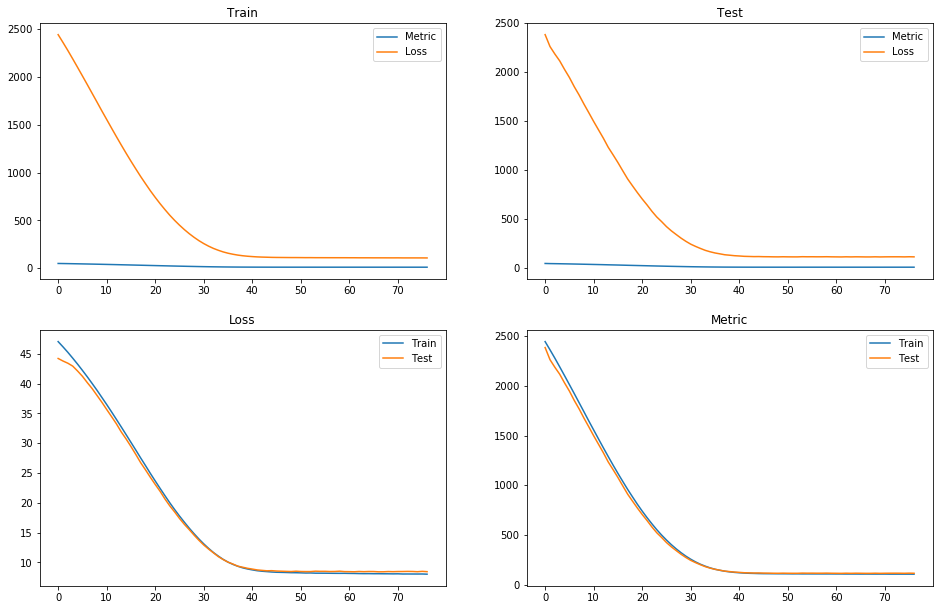

In [29]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')

In [44]:
X1_test = pd.read_csv('00_Data/fnc.csv')
X1_test = X1_test[X1_test['Id'].isin(TEST_IDS)]
X1_test = X1_test.to_numpy()
X1_test = X1_test[:,1:]

In [45]:
X2_test = pd.read_csv('00_Data/loading.csv')
X2_test = X2_test[X2_test['Id'].isin(TEST_IDS)]
X2_test = X2_test.to_numpy()
X2_test = X2_test[:,1:]

In [46]:
y_preds = model.predict([X1_test, X2_test])

In [47]:
y_preds = y_preds.flatten()

In [48]:
df_submission = []
i = 0
for idx in TEST_IDS:
    df_submission.append(['{0}_age'.format(idx), y_preds[i]])
    df_submission.append(['{0}_domain1_var1'.format(idx), y_preds[i+1]])
    df_submission.append(['{0}_domain1_var2'.format(idx), y_preds[i+2]])
    df_submission.append(['{0}_domain2_var1'.format(idx), y_preds[i+3]])
    df_submission.append(['{0}_domain2_var2'.format(idx), y_preds[i+4]])
    i += 5

df_submission = pd.DataFrame(df_submission, columns=['Id', 'Predicted'])

In [50]:
df_submission.to_csv('submission_fnc-load_mae_01.csv', index=False)